In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

warnings.filterwarnings(action='ignore')

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

plt.rc('font', family=font_name)

fm._rebuild()

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/구내식당 식수인원/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/구내식당 식수인원/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/구내식당 식수인원/sample_submission.csv')

In [ ]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


# 메뉴 New 확인

In [ ]:
train['조식new'] = train['조식메뉴'].apply(lambda x:1 if 'New' in x else 0)
train['중식new'] = train['중식메뉴'].apply(lambda x:1 if 'New' in x else 0)
train['석식new'] = train['석식메뉴'].apply(lambda x:1 if 'New' in x else 0)

In [ ]:
print(len(train[train['조식new']==1]))
print(len(train[train['중식new']==1]))
print(len(train[train['석식new']==1]))

2
26
21


In [ ]:
train[train['중식new']==1]['일자']

1109    2020-08-31
1111    2020-09-02
1118    2020-09-11
1121    2020-09-16
1123    2020-09-18
1133    2020-10-08
1136    2020-10-14
1137    2020-10-15
1141    2020-10-21
1146    2020-10-28
1147    2020-10-29
1149    2020-11-02
1151    2020-11-04
1154    2020-11-09
1161    2020-11-18
1164    2020-11-23
1165    2020-11-24
1167    2020-11-26
1171    2020-12-02
1173    2020-12-04
1179    2020-12-14
1181    2020-12-16
1182    2020-12-17
1186    2020-12-23
1187    2020-12-24
1194    2021-01-12
Name: 일자, dtype: object

#시계열 그래프

In [ ]:
train1 = train[train['일자']>'2020-01-01'].set_index('일자')

In [ ]:
train[train['중식new']==1].iloc[0]['일자']

'2020-08-31'

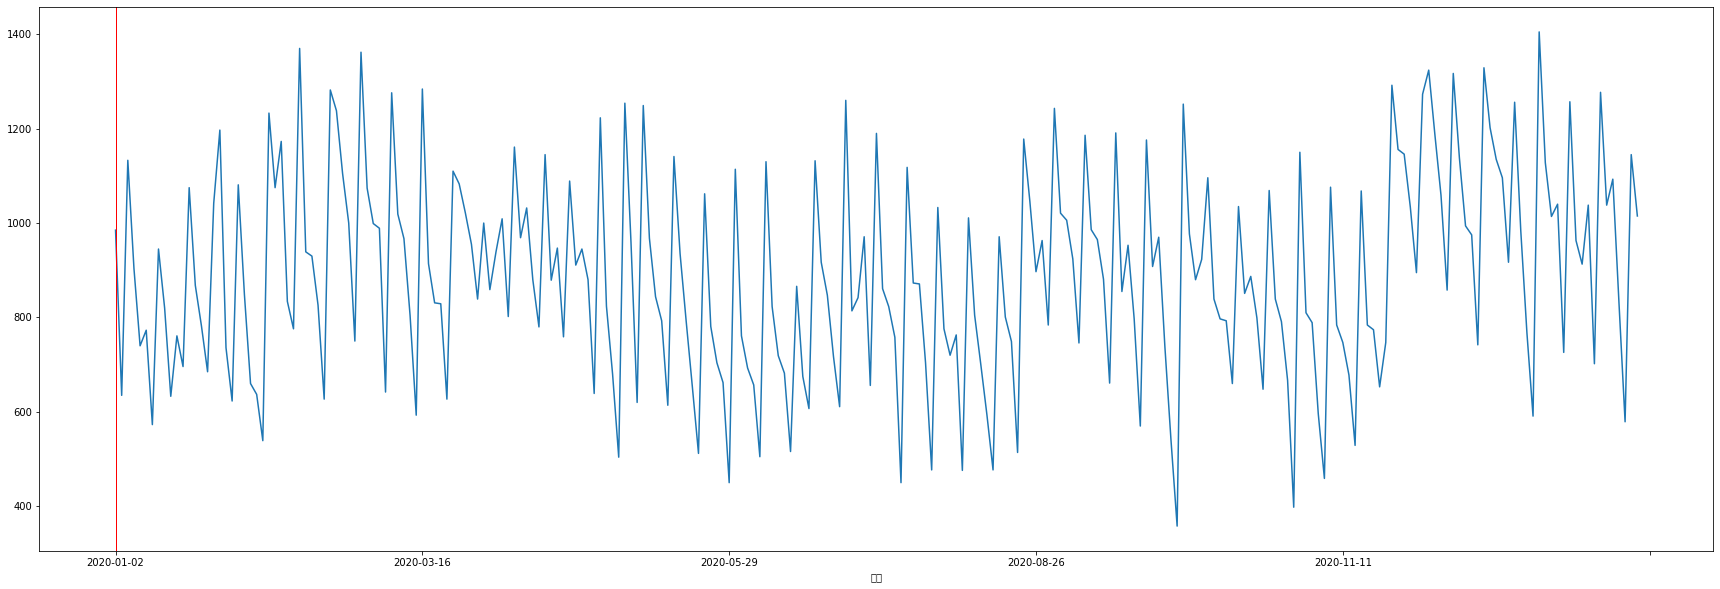

In [ ]:
plt.figure(figsize = (30, 10))
train1['중식계'].plot()
plt.axvline(x='2020-08-31', color='r', linestyle='-', linewidth=1)
plt.show()

In [ ]:
train[train['중식new']==1]

#메뉴 확인

In [ ]:
lunch = train['중식메뉴'].tolist()
dinner = train['석식메뉴'].tolist()

In [ ]:
lunch_menu = []
for i in range(len(lunch)):
  lunchs = lunch[i].split(" ")
  for j in range(len(lunchs)):
    lunch_menu.append(lunchs[j])
lunch_menu

dinner_menu = []
for i in range(len(dinner)):
  dinners = dinner[i].split(" ")
  for j in range(len(dinners)):
    dinner_menu.append(dinners[j])
dinner_menu

In [ ]:
from collections import Counter

sw = ['.', ',',' ','','(김치:국내산)','(쌀:국내산)','배추,고추가루:국내산)','(쌀,현미,흑미:국내산)',
      '(돈육:국내산)','(배추,고추가루:국내산)','(쇠고기:호주산)','(닭:국내산)','(쌀,현미흑미:국내산)','(소고기:호주산)','(닭고기:국내산)','(돼지고기:국내산)']
lunch_removed_list = []
for word in lunch_menu:
  if word.lower() not in sw:
    lunch_removed_list.append(word)


count_list = Counter(lunch_removed_list)

print(type(count_list))
print(count_list)
print()
common_cl = count_list.most_common(30) # top10
print(common_cl)
len(list(set(lunch_removed_list)))

<class 'collections.Counter'>
Counter({'쌀밥/잡곡밥': 879, '포기김치': 830, '배추겉절이': 95, '쌀밥/흑미밥/찰현미밥': 74, '열무김치': 67, '깍두기': 62, '알타리김치': 54, '맑은국': 46, '콩나물국': 44, '된장찌개': 38, '오이무침': 35, '오징어볶음': 32, '어묵국': 31, '닭갈비': 30, '버섯불고기': 29, '콩나물무침': 28, '배추된장국': 28, '계란말이': 28, '가쯔오장국': 28, '아욱국': 28, '훈제오리구이': 27, '근대국': 26, '꽃게탕': 25, '돈육굴소스볶음': 25, '계란찜': 24, '무생채': 24, '새송이버섯전': 24, '숙주나물': 24, '짬뽕불고기': 24, '요구르트': 23, '제육볶음': 23, '순두부찌개': 23, '콩나물밥': 23, '차돌박이찌개': 22, '언양식불고기': 22, '시금치나물': 21, '등갈비김치찜': 21, '미소장국': 21, '미역국': 21, '아삭고추무침': 20, '고추장찌개': 20, '육개장': 20, '열무된장국': 20, '마늘쫑무침': 19, '주꾸미볶음': 19, '유부장국': 19, '메추리알조림': 19, '어묵볶음': 19, '감자채볶음': 19, '카레덮밥': 18, '팽이장국': 18, '우엉잡채': 18, '도토리묵무침': 18, '쇠고기샤브국': 18, '시금치프리타타': 18, '닭볶음탕': 18, '(쌀,돈육:국내산)': 18, '시래기국': 17, '해물파전': 17, '골뱅이무침*소면': 17, '실곤약초무침': 17, '돈육김치찌개': 17, '고추잡채*꽃빵': 17, '쫑상추무침': 17, '부대찌개': 16, '동태전': 16, '부추생채': 16, '해물누룽지탕': 16, '양념깻잎지': 16, '(배추국내,고추가루:중국산)': 16, '치킨핑거': 15, '갈치구이': 15, '소불고기': 15, '미니채소떡갈비': 15, 

1786

In [ ]:
set(lunch_removed_list)

{'오이지무침',
 '풋마늘대무침',
 '도라지무침',
 '어묵꽈리고추조림',
 '쌈채소&쌈장',
 '대구찌개',
 '콩조림',
 '구운채소',
 '신김치도토리묵',
 '쇠고기무국',
 '콩자반/치킨무',
 '모듬묵흑임자샐러드',
 '닭살겨자냉채',
 '경상도식소고기국',
 '주꾸미굴소스볶음',
 '깍둑오이초무침',
 '민물새우찌개',
 '감자양파국',
 '참치야채전',
 '세발나물무침',
 '춘권',
 '콜리샐러드*발사믹D',
 '청경채나물',
 '돈육간장볶음',
 '참나물',
 '쌀밥/병아리콩/찰현미밥',
 '목살스테이크',
 '가지나물',
 '두부맛전',
 '연두부*양념',
 '연두부*양념장',
 '그린샐러드*참깨D',
 '마늘종숙회',
 '호박잎된장국',
 '동그랑땡',
 '채소계란말이',
 '양배추샐러드*딸기요거트D',
 '모둠장조림',
 '스팸계란전',
 '오이볶음',
 '떡밤초',
 '꼬지삼색전',
 '해물누룽지탕',
 '(',
 '새우까스*칠리소스',
 '홍합국',
 '상추&마늘',
 '야채고로케',
 '동파삼겹수육',
 '하와이언함박스테이크',
 '매운주꾸미볶음',
 '채소스틱&쌈장',
 '머위된장나물',
 '그린샐러드*오리엔탈D',
 '(주꾸미:베트남)',
 '돈삼겹보쌈',
 '매운소고기국',
 '멸치호두볶음',
 '목살데리야끼',
 '매운쇠고기샤브샤브',
 '시금치고추장나물',
 '어묵볶음',
 '골뱅이무침&소면',
 '우엉잡채',
 '꽁치김치말이찜',
 '조랭이떡미역국',
 '냉족발야채무침',
 '귤',
 '양상추샐러드*유자D',
 '오이도라지무침',
 '양배추쌈*젓장',
 '볶음김치',
 '시금치국',
 '부대찌개*라면사리',
 '갈치조림',
 '자몽에이드',
 '계란장조림',
 '(대구:원양산)',
 '요플레',
 '황도샐러드,포도주스',
 '크래미숙주무침',
 '(New)뿌리채소영양밥&달래양념장',
 '파래김*양념장',
 '생선까스*타르소스',
 '가래떡츄러스',
 '청경채깨장나물',
 '꽃상추겉절이',
 '셀프무쌈말이',
 '부럼/

In [ ]:
dinner_removed_list = []
for word in dinner_menu:
  if word.lower() not in sw:
    dinner_removed_list.append(word)


count_list = Counter(dinner_removed_list)

print(type(count_list))
print(count_list)
print()
common_cl = count_list.most_common(30) # top10
print(common_cl)
len(list(set(dinner_removed_list)))

<class 'collections.Counter'>
Counter({'포기김치': 894, '쌀밥/잡곡밥': 657, '흑미밥': 92, '깍두기': 81, '열무김치': 50, '알타리김치': 44, '잔치국수': 38, '석박지': 35, '맑은국': 34, '*': 33, '배추겉절이': 32, '꽃맛살샐러드': 31, '미소장국': 31, '된장찌개': 30, '단무지': 30, '가쯔오장국': 30, '육개장': 29, '김밥': 26, '단무지무침': 26, '멕시칸샐러드': 25, '유부초밥': 25, '부대찌개': 25, '우동': 23, '무피클': 23, '닭개장': 23, '오므라이스': 22, '과일샐러드': 21, '콩비지찌개': 21, '멸치주먹밥': 21, '유부장국': 21, '청국장찌개': 20, '떡볶이': 20, '쌀국수': 20, '콩나물국': 20, '무생채': 20, '콩나물무침': 19, '순두부찌개': 19, '부추생채': 19, '고추잡채*꽃빵': 19, '참치주먹밥': 19, '어묵국': 18, '열무된장국': 18, '쇠고기샤브국': 18, '가지나물': 18, '셀프무쌈말이': 18, '(배추국내,고추가루:중국산)': 18, '음료': 17, '아삭고추무침': 16, '닭갈비': 16, '감자채볶음': 16, '오이무침': 16, '동그랑땡전': 16, '청경채무침': 16, '계란찜': 16, '계란말이': 16, '충무김밥': 16, '고기전': 15, '꽃맛살볶음': 15, '옥수수전': 15, '마파두부': 15, '김치볶음밥': 15, '돈육강정': 15, '고등어구이': 15, '키위드레싱샐러드': 15, '양념깻잎지': 14, '돈육굴소스볶음': 14, '시금치나물': 14, '야채튀김': 14, '깐풍기': 14, '돈육장조림': 14, '유린기': 14, '황태양념구이': 13, '차돌박이찌개': 13, '참치회덮밥': 13, '락교': 13, '요플레': 13, '짬뽕': 13, '참나물생채

1755

#상관성 확인

In [ ]:
#상관계수
train.corr()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,중식new,조식new,석식new
본사정원수,1.000000,0.244666,-0.061688,0.146544,0.452293,-0.115529,-0.173852,0.187562,0.047083,0.165326
본사휴가자수,0.244666,1.000000,-0.273318,-0.230789,0.065397,-0.391975,-0.316894,0.038449,0.000024,0.017416
본사출장자수,-0.061688,-0.273318,1.000000,-0.308757,-0.352643,-0.512680,-0.188164,-0.071760,-0.022154,-0.092545
본사시간외근무명령서승인건수,0.146544,-0.230789,-0.308757,1.000000,0.156792,0.535611,0.571168,0.030815,0.084547,0.137034
현본사소속재택근무자수,0.452293,0.065397,-0.352643,0.156792,1.000000,0.076509,-0.057534,0.320675,0.081626,0.298612
중식계,-0.115529,-0.391975,-0.512680,0.535611,0.076509,1.000000,0.508287,0.036582,0.031866,0.049270
석식계,-0.173852,-0.316894,-0.188164,0.571168,-0.057534,0.508287,1.000000,-0.050706,0.024539,-0.002198
중식new,0.187562,0.038449,-0.071760,0.030815,0.320675,0.036582,-0.050706,1.000000,-0.006055,0.154812
조식new,0.047083,0.000024,-0.022154,0.084547,0.081626,0.031866,0.024539,-0.006055,1.000000,-0.005430
석식new,0.165326,0.017416,-0.092545,0.137034,0.298612,0.049270,-0.002198,0.154812,-0.005430,1.000000


In [ ]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

In [ ]:
%matplotlib inline

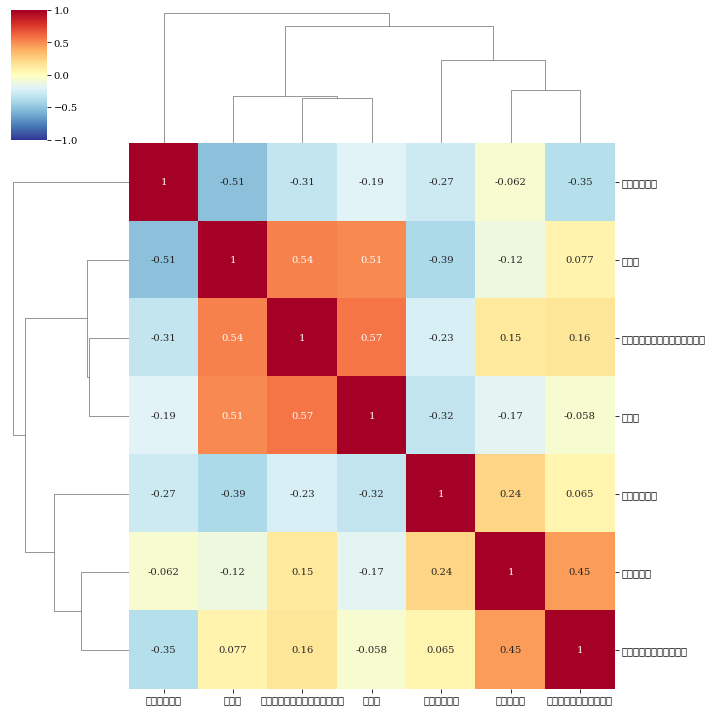

In [ ]:
sns.clustermap(train.corr(), 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )
plt.rc("font",family= 'Humor Sans')

In [ ]:
train[train['중식계']==1459]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
735,2019-02-11,월,2806,67,159,758,0.0,모닝롤/초코핫케익 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 콩나물국 두...,쌀밥/잡곡밥 (쌀:국내산) 어묵국 소불고기 (소고기:호주산) 계란말이 실곤약초무...,쌀밥/잡곡밥 (쌀:국내산) 된장찌개 닭볶음탕 (닭:국내산) 부추호박전 오이사과생...,1459.0,772.0


In [ ]:
train['본사정원수'].describe()

count    1205.000000
mean     2807.815768
std       171.264404
min      2601.000000
25%      2645.000000
50%      2760.000000
75%      2962.000000
max      3305.000000
Name: 본사정원수, dtype: float64

In [ ]:
train['중식계'].describe()

count    1205.000000
mean      890.334440
std       209.505057
min       296.000000
25%       758.000000
50%       879.000000
75%      1032.000000
max      1459.000000
Name: 중식계, dtype: float64

In [ ]:
train['조식메뉴'].tolist()

['모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐어채무침  포기김치 (배추,고추가루:국내산) ',
 '모닝롤/단호박샌드  우유/두유/주스 계란후라이  팥죽/쌀밥 (쌀:국내산) 호박젓국찌개  시래기조림  포기김치 (배추,고추가루:국내산) ',
 '모닝롤/베이글  우유/두유/주스 계란후라이  표고버섯죽/쌀밥 (쌀:국내산) 콩나물국  느타리호박볶음  포기김치 (배추,고추가루:국내산) ',
 '모닝롤/토마토샌드  우유/두유/주스 계란후라이  닭죽/쌀밥 (쌀,닭:국내산) 근대국  멸치볶음  포기김치 (배추,고추가루:국내산) ',
 '모닝롤/와플  우유/두유/주스 계란후라이  쇠고기죽/쌀밥 (쌀:국내산) 재첩국  방풍나물  포기김치 (배추,고추가루:국내산) ',
 '팬케익/찐빵  우유/두유/주스  계란후라이  견과류죽/쌀밥 (쌀:국내산) 감자찌개  명엽채무침 포기김치 (김치:국내산) ',
 '모닝롤/야채샌드  우유/두유/주스  계란후라이  고구마죽/쌀밥 (쌀:국내산) 봄동된장국  숙주나물 포기김치 (김치:국내산) ',
 '모닝롤/치즈프레즐  우유/두유/주스  계란후라이  잣죽/쌀밥 (쌀:국내산) 민물새우찌개  콩조림 포기김치 (김치:국내산) ',
 '모닝롤/마늘빵  우유/두유/주스  계란후라이  단호박죽/쌀밥 (쌀:국내산) 어묵국  김구이 포기김치 (김치:국내산) ',
 '모닝롤/참치샌드  우유/두유/주스  계란후라이  흑임자죽/쌀밥 (쌀:국내산) 북어계란국  무생채 포기김치 (김치:국내산) ',
 '모닝롤/인절미토스트  우유/두유/주스  계란후라이  계란후라이  (쌀:국내산) 선지해장국 (쇠고기:호주산) 톳두부무침 포기김치 (김치:국내산) ',
 '모닝롤/씨크립샌드  우유/두유/주스  계란후라이  밤죽/쌀밥 (쌀:국내산) 홍합탕  오이생채 포기김치 (김치:국내산) ',
 '모닝롤/팬케익  우유/주스  계란후라이  브로컬리죽/쌀밥 (쌀:국내산) 고추장찌개  시금치나물 포기김치 (고춧가루:국내산) ',
 '모닝롤/야채샌드  우유/주스 

# 메뉴 임베딩

In [ ]:
# Basic text preprocessing

def split_process(x, q):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

In [ ]:
food_combinations = []
for i in ['조식메뉴', '중식메뉴', '석식메뉴']:
    food_combinations += train[i].apply(lambda x: split_process(x, i)).to_list()

In [ ]:
train.iloc[0]['조식메뉴']

'모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐어채무침  포기김치 (배추,고추가루:국내산) '

In [ ]:
food_combinations

In [ ]:
# HYPER PARAMETERS

class CFG:
    emb_dim = 200

args = CFG

In [ ]:
args.emb_dim

200

In [ ]:
# Train or load w2v model

TRAIN_W2V = True
try:
    model = Word2Vec.load('/content/drive/MyDrive/Colab Notebooks/구내식당 식수인원/food_embedding.model')
    print("Model loaded")
except:
    if TRAIN_W2V:
        print("Training w2v")
        model = Word2Vec(sentences=food_combinations, size=args.emb_dim, window=7, min_count=0, workers=4, sg=0)
        model.save('/content/drive/MyDrive/Colab Notebooks/구내식당 식수인원/food_embedding.model')
    else:
        print("Model loading failed. Do not train.")

Training w2v


In [ ]:
# w2v demo
model.wv.most_similar('된장찌개')

[('찰현미밥', 0.9999619722366333),
 ('깍두기', 0.9999567270278931),
 ('열무김치', 0.999954104423523),
 ('흑미밥', 0.9999520182609558),
 ('잡곡밥', 0.9999513030052185),
 ('배추겉절이', 0.9999480247497559),
 ('알타리김치', 0.999947726726532),
 ('음료', 0.9999473690986633),
 ('석박지', 0.9999400973320007),
 ('유부장국', 0.9999396800994873)]

In [ ]:
def process_date(df):
    df['일자'] = pd.to_datetime(df['일자'], format="%Y-%m-%d")
    df['year'] = df['일자'].dt.year
    df['month'] = df['일자'].dt.month
    df['day'] = df['일자'].dt.day
    df = df.drop('일자', axis=1)
    return df

def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    vec_ = np.zeros(args.emb_dim)
    for i in x_:
        vec = model.wv.get_vector(i)
        vec_ += vec
    vec_ /= len(x_)
    return vec_

In [ ]:
# General preprocessing
df_train = process_date(train)
day_encoder = LabelEncoder()
df_train['요일'] = day_encoder.fit_transform(df_train['요일'])

In [ ]:
# Get embedding
df_train['조식메뉴_embedding'] = df_train['조식메뉴'].apply(lambda x: get_food_embedding(x))
df_train['중식메뉴_embedding'] = df_train['중식메뉴'].apply(lambda x: get_food_embedding(x))
df_train['석식메뉴_embedding'] = df_train['석식메뉴'].apply(lambda x: get_food_embedding(x))

In [ ]:
y_lunch = df_train['중식계']
y_dinner = df_train['석식계']
df_train.drop(['조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계'], axis=1, inplace=True)

In [ ]:
X_common = df_train.iloc[:, :9]

In [ ]:
emb_arr_lunch = np.array(df_train.iloc[:, 10].to_numpy().tolist()) # Ver 2
emb_arr_dinner = np.array(df_train.iloc[:, 11].to_numpy().tolist()) # Ver 2

X_train_lunch = np.concatenate((X_common.to_numpy(), emb_arr_lunch), axis=1)
X_train_dinner = np.concatenate((X_common.to_numpy(), emb_arr_dinner), axis=1)

ValueError: ignored

In [ ]:
X_train_lunch, X_test_lunch, y_train_lunch, y_test_lunch = train_test_split(X_train_lunch, y_lunch, test_size=0.1, random_state=42)
X_train_dinner, X_test_dinner, y_train_dinner, y_test_dinner = train_test_split(X_train_dinner, y_dinner, test_size=0.1, random_state=42)